In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt
import os
import keras
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Concatenate
from tensorflow.keras.optimizers import Adam


directory = 'Conor/'


In [2]:
def filteremg(emg, low_pass=3, sfreq=200, high_band=20, low_band=95, notch=60, quality=60):
    emg = emg - emg.mean()

    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)

    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass', analog=True)
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    emg_rectified = abs(emg_filtered)

    notch = notch/(sfreq/2)
    b2, a2 = sp.signal.iirnotch(notch, quality)
    emg_notched = sp.signal.filtfilt(b2, a2, emg_rectified)

    emg_envelope = sp.signal.lfilter(b2, a2, emg_notched)

    return emg_envelope

def mav(emg_signal):
    return np.mean(np.abs(emg_signal))

def get_RMS(signal):
    return np.sqrt(np.average(np.square(signal)))

def get_WL(signal):
    return np.log(sum([np.absolute(signal[i+1] - signal[i]) for i in range(len(signal)-1)]))

def get_MAV(signal):
    return np.average(np.absolute(signal))

def get_VAR(signal):
    return np.var(signal)

def get_MAXP(signal):
    f, Pxx_den = sp.signal.periodogram(signal, 200)
    return max(Pxx_den)

def get_dRange(signal):
    return max(signal) - min(signal)

def get_MAX(signal):
    return max(signal)

def extract_features(dataframe, emg_channels, or_channels, gyro_channels, acc_channels):
    feat_dict = {}
    for chan in emg_channels:
        feat_dict[chan + '_RMS'] = get_RMS(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_WL'] = get_WL(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_MAV'] = get_MAV(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_VAR'] = get_VAR(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_MAXP'] = get_MAXP(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_MAX'] = get_MAX(dataframe[chan].dropna().reset_index(drop=True))
    for chan in or_channels:
        feat_dict[chan + '_dOrient'] = get_dRange(dataframe[chan].dropna().reset_index(drop=True))
    for chan in gyro_channels:
        feat_dict[chan + '_dGyro'] = get_dRange(dataframe[chan].dropna().reset_index(drop=True))
    for chan in or_channels + gyro_channels + acc_channels:
        feat_dict[chan + '_VAR'] = get_VAR(dataframe[chan].dropna().reset_index(drop=True))
    for chan in acc_channels:
        feat_dict[chan + '_MAX'] = get_MAX(dataframe[chan].dropna().reset_index(drop=True))
    return feat_dict

In [3]:
import re

directories = [r"C:\Users\conor\Documents\VSCode Projects\biorobotics cybernetics\project\Conor\One\Thalmic Labs MyoMyo", 
               r"C:\Users\conor\Documents\VSCode Projects\biorobotics cybernetics\project\John\One\Thalmic Labs MyoMyo",
               r"C:\Users\conor\Documents\VSCode Projects\biorobotics cybernetics\project\Aharon\One\Thalmic Labs MyoMyo"]

emg_features_df = pd.DataFrame()
imu_features_df = pd.DataFrame()

emg_keys = ['EMG_' + str(i) for i in range(1, 9)]
imu_keys = ['Orientation_X','Orientation_Y','Orientation_Z','Gyro_X','Gyro_Y','Gyro_Z','Acc_X', 'Acc_Y', 'Acc_Z']
or_keys = imu_keys[:4]
gyro_keys = imu_keys[4:7]
acc_keys = imu_keys[7:]

for directory in directories:
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            # Modify this line to use a regular expression for label extraction
            label = re.match(r"([a-z_]+)_", file).group(1)

            emg_df = pd.read_csv(os.path.join(directory, file))
            emg_df.columns = emg_df.columns.str.replace(' ', '')

            filt_emg = emg_df.copy()
            filt_emg[emg_keys] = filt_emg[emg_keys].apply(filteremg, raw=True)
            filt_emg[emg_keys] = filt_emg[emg_keys].apply(lambda x: x.rolling(20).mean())
            filt_emg[imu_keys] = filt_emg[imu_keys].apply(lambda x: x.rolling(5).mean())
            filt_emg.dropna(inplace=True)

            features = extract_features(filt_emg, emg_keys, or_keys, gyro_keys, acc_keys)
            features["label"] = label

            emg_feature_row = {key: features[key] for key in features if key.startswith("EMG_")}
            imu_feature_row = {key: features[key] for key in features if key.startswith(("Orientation", "Gyro", "Acc"))}

            emg_feature_row["label"] = label
            imu_feature_row["label"] = label

            emg_features_df = pd.concat([emg_features_df, pd.DataFrame(emg_feature_row, index=[0])], ignore_index=True)
            imu_features_df = pd.concat([imu_features_df, pd.DataFrame(imu_feature_row, index=[0])], ignore_index=True)




In [4]:
print("EMG Features:")
display(emg_features_df)
print("IMU Features:")
display(imu_features_df)


EMG Features:


,EMG_1_RMS,EMG_1_WL,EMG_1_MAV,EMG_1_VAR,EMG_1_MAXP,EMG_1_MAX,EMG_2_RMS,EMG_2_WL,EMG_2_MAV,EMG_2_VAR,...,EMG_7_VAR,EMG_7_MAXP,EMG_7_MAX,EMG_8_RMS,EMG_8_WL,EMG_8_MAV,EMG_8_VAR,EMG_8_MAXP,EMG_8_MAX,label
0,12.211929,4.524596,11.602301,14.517813,4.945438,17.635832,20.144135,4.946144,18.740911,54.564452,...,108.541988,47.460225,41.025093,21.560893,5.117465,15.770201,216.172876,104.997952,59.074882,backward
1,19.629317,4.721807,17.224607,88.622995,54.255423,37.152836,24.701615,4.980295,21.565368,145.104695,...,11.565766,4.638866,14.145555,24.021747,4.923720,20.235423,167.571990,83.059246,50.734338,backward
2,9.179456,4.740726,8.470560,12.512029,6.386703,17.128107,12.784221,4.949869,11.696662,26.624420,...,6.189367,5.223363,10.509018,18.001325,5.368053,12.364455,171.167963,145.087753,54.660172,backward
3,10.497993,4.229409,9.912437,11.951455,3.582766,18.133384,19.116430,4.842842,17.815632,48.041138,...,86.618131,29.516047,40.410894,13.185364,4.390236,12.718636,12.090120,6.527145,20.782620,backward
4,11.626216,4.426033,11.005957,14.037821,6.298201,22.686267,21.785356,5.087622,20.564759,51.692418,...,15.816759,9.177808,17.402650,14.469563,4.424735,12.569901,51.365834,32.777702,25.200034,backward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,18.257832,4.675712,12.956420,165.479598,45.468311,65.316847,30.572508,5.292453,28.033257,148.814733,...,1.550680,0.619236,6.329849,4.739422,3.264497,4.499164,2.219645,0.890875,7.683649,up
296,29.837364,6.094701,25.832117,222.969987,160.466079,84.360220,28.905315,6.180105,27.451196,81.949053,...,38.008681,25.854919,33.101917,15.515317,5.575939,14.242711,37.870252,26.577003,34.133827,up
297,27.107999,5.254420,25.961303,60.854351,13.897216,47.566767,43.660413,5.928973,39.204894,369.207949,...,154.974111,58.813234,57.049807,33.597599,5.524226,30.341780,208.175021,84.580439,62.451607,up
298,25.877693,5.167778,24.719903,58.581402,26.009347,40.923005,42.701013,5.828144,39.103920,294.259998,...,190.238021,72.025995,56.997257,43.246727,5.641518,41.041011,185.914816,40.924256,62.171117,up


IMU Features:


,Orientation_X_dOrient,Orientation_Y_dOrient,Orientation_Z_dOrient,Gyro_X_dOrient,Gyro_Y_dGyro,Gyro_Z_dGyro,Acc_X_dGyro,Orientation_X_VAR,Orientation_Y_VAR,Orientation_Z_VAR,Gyro_X_VAR,Gyro_Y_VAR,Gyro_Z_VAR,Acc_X_VAR,Acc_Y_VAR,Acc_Z_VAR,Acc_Y_MAX,Acc_Z_MAX,label
0,0.076245,0.069604,0.192725,53.3375,99.3750,97.6500,0.544629,0.000741,0.000370,0.004124,142.032738,524.510707,546.127010,0.018729,0.003105,0.001361,-0.867871,0.211230,backward
1,0.075085,0.060962,0.115088,74.5375,54.9250,81.3625,0.480762,0.000596,0.000486,0.001744,186.470317,160.917128,314.561575,0.019463,0.001645,0.001577,-0.919629,0.092969,backward
2,0.102625,0.109656,0.188013,101.1250,70.1500,75.9000,0.465918,0.001141,0.001312,0.003510,201.976892,117.389518,316.490582,0.017213,0.002225,0.002598,-0.805469,0.176172,backward
3,0.141797,0.065735,0.135535,60.4500,76.6000,117.8250,0.770605,0.002331,0.000521,0.002740,106.345033,238.203645,678.991853,0.037327,0.005402,0.000861,-0.857715,0.099902,backward
4,0.082141,0.046606,0.112451,59.9750,73.9875,85.8125,0.691699,0.000996,0.000310,0.002071,86.264018,200.907078,348.239184,0.031682,0.003065,0.000694,-0.869141,0.147754,backward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.691150,0.260010,0.065601,95.8125,65.5375,101.5125,1.031934,0.081637,0.011649,0.000510,893.509040,303.432077,1227.491058,0.163298,0.205624,0.013650,-0.031055,0.419531,up
296,0.236047,0.725696,0.208008,126.5625,133.1750,68.4875,1.091113,0.005743,0.084183,0.003387,1019.684742,958.229350,118.050183,0.120060,0.133470,0.052061,0.721484,1.059082,up
297,0.388635,0.735925,0.200989,133.0125,91.0250,72.7625,1.075879,0.021868,0.085401,0.004076,1382.563201,988.805498,271.078439,0.159368,0.132640,0.088722,0.726367,1.093262,up
298,0.468213,0.619995,0.156799,157.3000,112.9250,60.8250,0.937402,0.037212,0.067977,0.002568,2086.078417,1131.495538,247.911936,0.143499,0.159700,0.095546,0.775391,1.281250,up


In [5]:
print(imu_features_df['label'].value_counts())


backward        20
down            20
fist            20
forward         20
left            20
resting         20
right           20
rotate_down     20
rotate_left     20
rotate_right    20
rotate_up       20
stop            20
twistleft       20
twistright      20
up              20
Name: label, dtype: int64


In [6]:
train_cols = ['EMG_1_RMS', 'EMG_1_WL', 'EMG_1_MAV', 'EMG_1_VAR', 'EMG_1_MAXP', 'EMG_1_MAX',
              'EMG_2_RMS', 'EMG_2_WL', 'EMG_2_MAV', 'EMG_2_VAR', 'EMG_2_MAXP', 'EMG_2_MAX',
              'EMG_3_RMS', 'EMG_3_WL', 'EMG_3_MAV', 'EMG_3_VAR', 'EMG_3_MAXP', 'EMG_3_MAX',
              'EMG_4_RMS', 'EMG_4_WL', 'EMG_4_MAV', 'EMG_4_VAR', 'EMG_4_MAXP', 'EMG_4_MAX',
              'EMG_5_RMS', 'EMG_5_WL', 'EMG_5_MAV', 'EMG_5_VAR', 'EMG_5_MAXP', 'EMG_5_MAX',
              'EMG_6_RMS', 'EMG_6_WL', 'EMG_6_MAV', 'EMG_6_VAR', 'EMG_6_MAXP', 'EMG_6_MAX',
              'EMG_7_RMS', 'EMG_7_WL', 'EMG_7_MAV', 'EMG_7_VAR', 'EMG_7_MAXP', 'EMG_7_MAX',
              'EMG_8_RMS', 'EMG_8_WL', 'EMG_8_MAV', 'EMG_8_VAR', 'EMG_8_MAXP', 'EMG_8_MAX']

df_train, df_test = train_test_split(emg_features_df, train_size=0.8, test_size=0.2, shuffle=True, stratify=emg_features_df['label'])


x_train = df_train.loc[:, train_cols].values
y_train = df_train.loc[:, 'label'].values
x_test = df_test.loc[:, train_cols].values
y_test = df_test.loc[:, 'label'].values


min_max_scaler = MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)
x_test_scaled = min_max_scaler.transform(x_test)


combined_labels = np.concatenate((y_train, y_test))

label_encoder = LabelEncoder()
combined_labels_int = label_encoder.fit_transform(combined_labels)
label_encoder.fit(y_train)



y_train_int = combined_labels_int[:len(y_train)]
y_test_int = combined_labels_int[len(y_train):]

imu_train_cols = ['Orientation_X_dOrient', 'Orientation_Y_dOrient', 'Orientation_Z_dOrient', 'Gyro_X_dOrient', 'Gyro_Y_dGyro', 'Gyro_Z_dGyro', 'Acc_X_dGyro', 'Acc_Y_MAX', 'Acc_Z_MAX']

df_train_imu, df_test_imu = train_test_split(imu_features_df, train_size=0.8, test_size=0.2, shuffle=True, stratify=imu_features_df['label'])

x_train_imu = df_train_imu.loc[:, imu_train_cols].values
y_train_imu = df_train_imu.loc[:, 'label'].values
x_test_imu = df_test_imu.loc[:, imu_train_cols].values
y_test_imu = df_test_imu.loc[:, 'label'].values

x_train_scaled_imu = min_max_scaler.fit_transform(x_train_imu)
x_test_scaled_imu = min_max_scaler.transform(x_test_imu)

combined_labels_imu = np.concatenate((y_train_imu, y_test_imu))
combined_labels_int_imu = label_encoder.fit_transform(combined_labels_imu)

y_train_int_imu = combined_labels_int_imu[:len(y_train_imu)]
y_test_int_imu = combined_labels_int_imu[len(y_train_imu):]


In [7]:
def build_timeseries(mat, y_labels, TIME_STEPS):
    # y_labels is the array of output labels
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0, y_labels.shape[1]))  # fixed  y array to match the number of classes
    
    for i in range(dim_0 - TIME_STEPS):
        x[i] = mat[i:i+TIME_STEPS]
        y[i] = y_labels[TIME_STEPS+i]
        
    print("length of time-series i/o", x.shape, y.shape)
    return x, y



def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [8]:
num_classes = len(np.unique(combined_labels_int))
y_train_encoded = to_categorical(y_train_int, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_int, num_classes=num_classes)


TIME_STEPS = 1 #doesnt help because the extracted features arent temporal
BATCH_SIZE = 24
x_t, y_t = build_timeseries(x_train, y_train_encoded, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, y_test_encoded, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (239, 1, 48) (239, 15)
length of time-series i/o (59, 1, 48) (59, 15)


In [9]:
lstm_model_emg = Sequential()
lstm_model_emg.add(LSTM(256, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(1e-4)))
lstm_model_emg.add(Dropout(0.65))
lstm_model_emg.add(Dense(128, activation='relu'))
lstm_model_emg.add(Dense(num_classes, activation='softmax'))
lstm_model_emg.add(Dense(64, activation='relu'))
lstm_model_emg.add(Dense(num_classes, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model_emg.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Epoch 1/100
9/9 [==============================] - 2s 50ms/step - loss: 2.7157 - accuracy: 0.0694 - val_loss: 2.7135 - val_accuracy: 0.0833
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7163 - accuracy: 0.0787 - val_loss: 2.7139 - val_accuracy: 0.0833
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7152 - accuracy: 0.0694 - val_loss: 2.7141 - val_accuracy: 0.0833
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7146 - accuracy: 0.0880 - val_loss: 2.7142 - val_accuracy: 0.0833
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 2.7124 - accuracy: 0.1065 - val_loss: 2.7149 - val_accuracy: 0.0833
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7132 - accuracy: 0.0602 - val_loss: 2.7149 - val_accuracy: 0.0417
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7116 - accuracy: 0.0741 - val_loss: 2.7149 - val_accuracy: 0.0417
Epoch 8/100
9/9 [=========

INFO:tensorflow:Assets written to: lstm emg model\assets


INFO:tensorflow:Assets written to: lstm emg model\assets


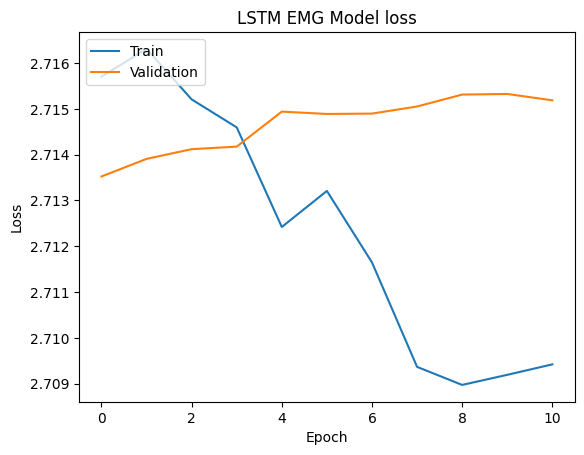

In [10]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_emg = lstm_model_emg.fit(x_t, y_t, batch_size=BATCH_SIZE, epochs=100, verbose=1,
    validation_data=(trim_dataset(x_val, BATCH_SIZE), trim_dataset(y_val, BATCH_SIZE)),
    callbacks=[early_stopping])


lstm_model_emg.save("lstm emg model")
plt.figure()
plt.plot(history_emg.history['loss'])
plt.plot(history_emg.history['val_loss'])
plt.title('LSTM EMG Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

1/1 [==============================] - 0s 17ms/step - loss: 2.7217 - accuracy: 0.0417
Test score (EMG): 2.721663236618042
Test accuracy (EMG): 0.0416666679084301
1/1 [==============================] - 0s 298ms/step


c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall 

,precision,recall,f1-score,support
1,0.000000,0.000000,0.000000,3.000000
2,0.000000,0.000000,0.000000,2.000000
3,0.000000,0.000000,0.000000,3.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,2.000000
6,0.000000,0.000000,0.000000,1.000000
7,0.000000,0.000000,0.000000,1.000000
8,0.000000,0.000000,0.000000,3.000000
9,0.000000,0.000000,0.000000,3.000000
10,0.250000,0.500000,0.333333,2.000000


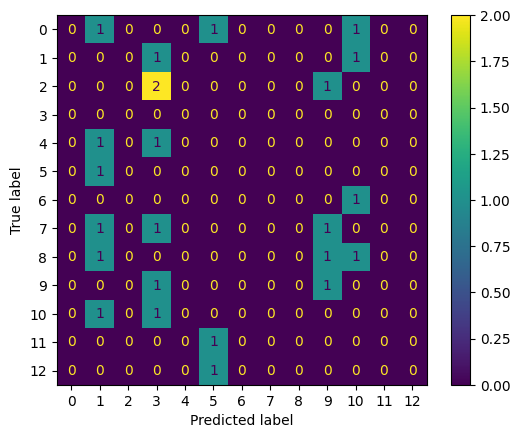

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

score_emg = lstm_model_emg.evaluate(x_test_t, y_test_t, verbose=1, batch_size=BATCH_SIZE)
print('Test score (EMG):', score_emg[0])
print('Test accuracy (EMG):', score_emg[1])

predicted_emg = lstm_model_emg.predict(x_test_t)
predicted_emg = np.argmax(predicted_emg, axis=1)
true_emg = np.argmax(y_test_t, axis=1)

report_emg = classification_report(true_emg, predicted_emg, output_dict=True)
display(pd.DataFrame(report_emg).transpose())

cm_emg = confusion_matrix(true_emg, predicted_emg)
disp_emg = ConfusionMatrixDisplay(confusion_matrix=cm_emg)
disp_emg.plot()

In [12]:
y_train_encoded_imu = to_categorical(y_train_int_imu, num_classes=num_classes)
y_test_encoded_imu = to_categorical(y_test_int_imu, num_classes=num_classes)


x_t_imu, y_t_imu = build_timeseries(x_train_scaled_imu, y_train_encoded_imu, TIME_STEPS)
x_t_imu = trim_dataset(x_t_imu, BATCH_SIZE)
y_t_imu = trim_dataset(y_t_imu, BATCH_SIZE)
x_temp_imu, y_temp_imu = build_timeseries(x_test_scaled_imu, y_test_encoded_imu, TIME_STEPS)
x_val_imu, x_test_t_imu = np.split(trim_dataset(x_temp_imu, BATCH_SIZE), 2)
y_val_imu, y_test_t_imu = np.split(trim_dataset(y_temp_imu, BATCH_SIZE), 2)

lstm_model_imu = Sequential()
lstm_model_imu.add(LSTM(256, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t_imu.shape[2]), dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(1e-4)))
lstm_model_imu.add(Dropout(0.65))
lstm_model_imu.add(Dense(128, activation='relu'))
lstm_model_imu.add(Dense(num_classes, activation='softmax'))
lstm_model_imu.add(Dense(64, activation='relu'))
lstm_model_imu.add(Dense(num_classes, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model_imu.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

length of time-series i/o (239, 1, 9) (239, 15)
length of time-series i/o (59, 1, 9) (59, 15)


Epoch 1/100
9/9 [==============================] - 1s 47ms/step - loss: 2.7097 - accuracy: 0.0741 - val_loss: 2.7055 - val_accuracy: 0.1250
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7095 - accuracy: 0.0694 - val_loss: 2.7054 - val_accuracy: 0.1250
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7094 - accuracy: 0.0741 - val_loss: 2.7054 - val_accuracy: 0.1250
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7092 - accuracy: 0.0741 - val_loss: 2.7055 - val_accuracy: 0.1250
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 2.7091 - accuracy: 0.0741 - val_loss: 2.7054 - val_accuracy: 0.1250
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7090 - accuracy: 0.0741 - val_loss: 2.7053 - val_accuracy: 0.1250
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 2.7088 - accuracy: 0.0741 - val_loss: 2.7052 - val_accuracy: 0.1250
Epoch 8/100
9/9 [=========

INFO:tensorflow:Assets written to: lstm model imu\assets


INFO:tensorflow:Assets written to: lstm model imu\assets


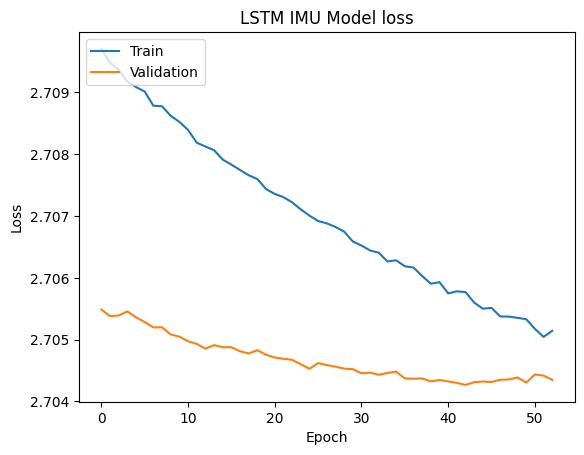

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_imu = lstm_model_imu.fit(x_t_imu, y_t_imu, batch_size=BATCH_SIZE, epochs=100, verbose=1,
    validation_data=(trim_dataset(x_val_imu, BATCH_SIZE), trim_dataset(y_val_imu, BATCH_SIZE)),
    callbacks=[early_stopping])


lstm_model_imu.save("lstm model imu")
plt.figure()
plt.plot(history_imu.history['loss'])
plt.plot(history_imu.history['val_loss'])
plt.title('LSTM IMU Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

1/1 [==============================] - 0s 17ms/step - loss: 2.7124 - accuracy: 0.0417
Test score (IMU): 2.712390184402466
Test accuracy (IMU): 0.0416666679084301
1/1 [==============================] - 0s 282ms/step


c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,2.000000
1,0.000000,0.000000,0.000000,2.000000
2,0.000000,0.000000,0.000000,2.000000
3,0.000000,0.000000,0.000000,2.000000
4,0.000000,0.000000,0.000000,2.000000
5,0.000000,0.000000,0.000000,2.000000
6,0.000000,0.000000,0.000000,2.000000
7,0.000000,0.000000,0.000000,1.000000
8,0.000000,0.000000,0.000000,1.000000
9,0.000000,0.000000,0.000000,1.000000


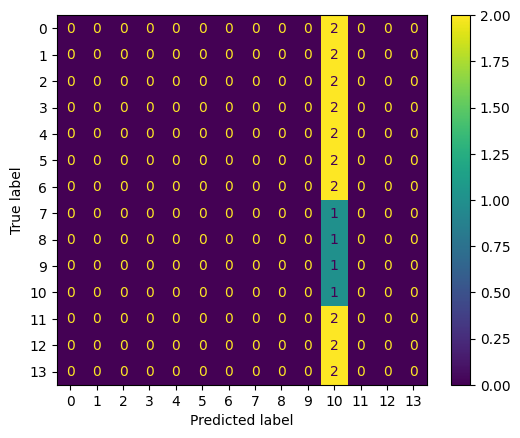

In [14]:
score_imu = lstm_model_imu.evaluate(x_test_t_imu, y_test_t_imu, verbose=1, batch_size=BATCH_SIZE)
print('Test score (IMU):', score_imu[0])
print('Test accuracy (IMU):', score_imu[1])

predicted_imu = lstm_model_imu.predict(x_test_t_imu)
predicted_imu = np.argmax(predicted_imu, axis=1)
true_imu = np.argmax(y_test_t_imu, axis=1)

report_imu = classification_report(true_imu, predicted_imu, output_dict=True)
display(pd.DataFrame(report_imu).transpose())

cm_imu = confusion_matrix(true_imu, predicted_imu)
disp_imu = ConfusionMatrixDisplay(confusion_matrix=cm_imu)
disp_imu.plot()

In [15]:
emg_feature_model = Model(inputs=lstm_model_emg.input, outputs=lstm_model_emg.layers[-2].output)
imu_feature_model = Model(inputs=lstm_model_imu.input, outputs=lstm_model_imu.layers[-2].output)

concatenated_features = Concatenate()([emg_feature_model.output, imu_feature_model.output])

fusion_output = Dense(num_classes, activation='softmax')(concatenated_features)
fusion_model = Model(inputs=[emg_feature_model.input, imu_feature_model.input], outputs=fusion_output)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
fusion_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

x_t_fusion = [x_t, x_t_imu]
x_val_fusion = [trim_dataset(x_val, BATCH_SIZE), trim_dataset(x_val_imu, BATCH_SIZE)]
x_test_t_fusion = [x_test_t, x_test_t_imu]



Epoch 1/100
9/9 [==============================] - 2s 74ms/step - loss: 2.7175 - accuracy: 0.0556 - val_loss: 2.7210 - val_accuracy: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 2.7167 - accuracy: 0.0648 - val_loss: 2.7210 - val_accuracy: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 2.7172 - accuracy: 0.0880 - val_loss: 2.7211 - val_accuracy: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 2.7163 - accuracy: 0.0694 - val_loss: 2.7212 - val_accuracy: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 2.7140 - accuracy: 0.0694 - val_loss: 2.7212 - val_accuracy: 0.0000e+00
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 2.7137 - accuracy: 0.0880 - val_loss: 2.7210 - val_accuracy: 0.0000e+00
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 2.7132 - accuracy: 0.0833 - val_loss: 2.7209 - val_accuracy: 0.0000e+0

INFO:tensorflow:Assets written to: fusion model\assets


INFO:tensorflow:Assets written to: fusion model\assets


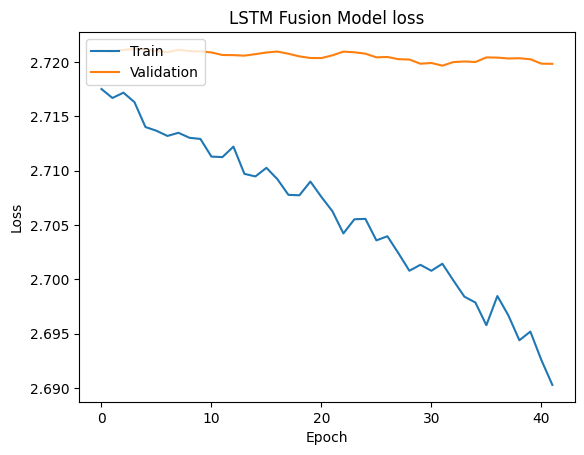

In [16]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_fusion = fusion_model.fit(x_t_fusion, y_t, batch_size=BATCH_SIZE, epochs=100, verbose=1,
                                  validation_data=(x_val_fusion, trim_dataset(y_val, BATCH_SIZE)),
                                  callbacks=[early_stopping])

fusion_model.save("fusion model")
plt.figure()
plt.plot(history_fusion.history['loss'])
plt.plot(history_fusion.history['val_loss'])
plt.title('LSTM Fusion Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


1/1 [==============================] - 0s 18ms/step - loss: 2.7103 - accuracy: 0.0417
Test score (Fusion): 2.7102737426757812
Test accuracy (Fusion): 0.0416666679084301
1/1 [==============================] - 0s 473ms/step


c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.000000,0.000000,0.000000,3.000000
2,0.066667,0.500000,0.117647,2.000000
3,0.000000,0.000000,0.000000,3.000000
5,0.000000,0.000000,0.000000,2.000000
6,0.000000,0.000000,0.000000,1.000000
7,0.000000,0.000000,0.000000,1.000000
8,0.000000,0.000000,0.000000,3.000000
9,0.000000,0.000000,0.000000,3.000000
10,0.000000,0.000000,0.000000,2.000000
11,0.000000,0.000000,0.000000,2.000000


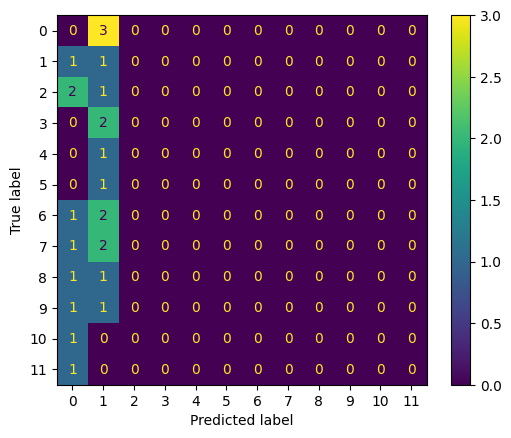

In [17]:
score_fusion = fusion_model.evaluate(x_test_t_fusion, y_test_t, verbose=1, batch_size=BATCH_SIZE)
print('Test score (Fusion):', score_fusion[0])
print('Test accuracy (Fusion):', score_fusion[1])

predicted_fusion = fusion_model.predict(x_test_t_fusion)
predicted_fusion = np.argmax(predicted_fusion, axis=1)
true_fusion = np.argmax(y_test_t, axis=1)
report_fusion = classification_report(true_fusion, predicted_fusion, output_dict=True)
display(pd.DataFrame(report_fusion).transpose())
cm_fusion = confusion_matrix(true_fusion, predicted_fusion)
disp_fusion = ConfusionMatrixDisplay(confusion_matrix=cm_fusion)
disp_fusion.plot()